<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/%5BDSO%5D%E5%8B%89%E5%BC%B7%E4%BC%9A_%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9%E8%AC%9B%E7%BE%A9_Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MovieLensのデータを読み込む

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances

# movie lensのデータの読み込み
rating = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', names=["user_id", "item_id", "rating", "timestamp"], sep="\t")
rating.head(10)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


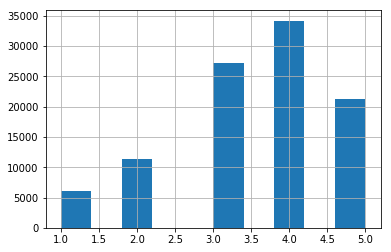

In [2]:
rating.rating.hist();

In [0]:
import urllib, chardet
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
u = chardet.UniversalDetector()
u.feed(urllib.request.urlopen(url).read())
u.close()

movies = pd.read_csv(url, sep='|', names=["movie_id","movie_title","release_date","videorelease_date","IMDb_URL",
                                                                           "unknown","Action","Adventure","Animation","Childrens","Comedy","Crime",
                                                                           "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery",
                                                                           "Romance","Sci-Fi","Thriller","War","Western"],
                              usecols = range(24), encoding='iso-8859-1')

In [0]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
u = chardet.UniversalDetector()
u.feed(urllib.request.urlopen(url).read())
u.close()

user = pd.read_csv(url, sep='|', names=["user_id","age","gender","occupation","zip_code"],
                              usecols = range(5), encoding='iso-8859-1')

In [0]:
user.gender =  pd.Categorical(user.gender)
user.occupation =  pd.Categorical(user.occupation)

In [0]:
gender_dummy = pd.get_dummies(user.gender ,drop_first=True)
occupation_dummy = pd.get_dummies(user.occupation ,drop_first=True)

In [0]:
dataset = user[["user_id","age", "zip_code"]]
dataset = pd.concat([ dataset, 
                   gender_dummy,
                   occupation_dummy
                   ], axis=1)

In [0]:
rating_matrix = pd.pivot_table(data=rating,
                            fill_value=3,
                            index="user_id", columns="item_id",aggfunc = {  'rating' : "sum" } ).reset_index()

In [0]:
column_name = ["user_id"]
column_name.extend(rating.sort_values(by=["item_id"]).item_id.unique().tolist())

In [0]:
rating_matrix.columns = column_name

In [0]:
rating_use = pd.merge(rating_matrix, dataset, on="user_id", how="left")
rating_use = rating_use.drop(columns=["zip_code"],axis=1)

In [12]:
rating_use.head(3)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,age,M,artist,doctor,educator,engineer,entertainment,executive,healthcare,homemaker,lawyer,librarian,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,1,5,3,4,3,3,5,4,1,5,3,2,5,5,5,5,5,3,4,5,4,1,4,4,3,4,3,2,4,1,3,3,5,4,2,1,2,2,3,4,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2,4,3,3,3,3,3,3,3,3,2,3,3,4,4,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,53,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [0]:
X_train, X_test, y_train, y_test = train_test_split(rating_use.iloc[:,2:1683], #1683
                                                                                        rating_use.iloc[:,1], 
                                                                                        stratify=rating_use.iloc[:,1],
                                                                                        test_size=0.2,
                                                                                        random_state=123)

scalar = StandardScaler()
scalar.fit(X_train)

X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

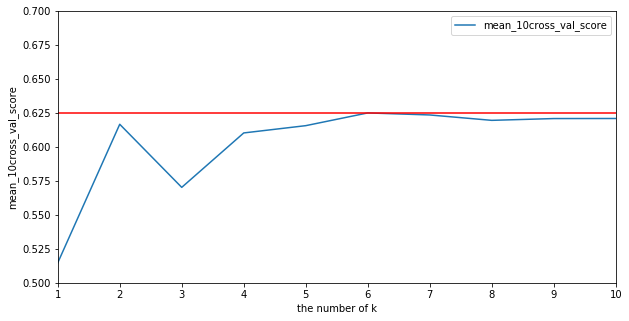

In [18]:
iteration = 11
result_table = pd.DataFrame(columns=["k", "mean_10cross_val_score"])
for i in range(1,iteration):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=10)
    
    df = pd.DataFrame([[i,knn_scores.mean()]], columns=result_table.columns)
    result_table = result_table.append(df).reset_index(drop=True)
    
ax = result_table.plot(x="k",y="mean_10cross_val_score", figsize=(10,5));
ax.set_ylabel("mean_10cross_val_score");
ax.set_xlabel("the number of k");
ax.axhline(y=0.625, color='r', linestyle='-')
ax.set_ylim([0.5, 0.7]);

## Ridge回帰（L2正則化）

In [0]:
from sklearn.linear_model import  RidgeCV

In [21]:
X_train, X_test, y_train, y_test = train_test_split(rating_use.iloc[:,1683:],
                                                                                        rating_use.iloc[:,1], 
                                                                                        stratify=rating_use.iloc[:,1],
                                                                                        test_size=0.2,
                                                                                        random_state=123)

scalar = StandardScaler()
scalar.fit(X_train)

X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)


rcv = RidgeCV(alphas=np.array([.1, .2, .3, .4]))
rcv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [22]:
rcv.alpha_

0.4

In [23]:
rcv2 = RidgeCV(alphas=np.array([.38,.39,.40,.41,.42]))
rcv2.fit(X_train_scaled, y_train)
rcv.alpha_

0.4

In [24]:
alphas_to_test = np.linspace(0.01, 2000)
rcv3 = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv3.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 4.08261224e+01, 8.16422449e+01, 1.22458367e+02,
       1.63274490e+02, 2.04090612e+02, 2.44906735e+02, 2.85722857e+02,
       3.26538980e+02, 3.67355102e+02, 4.08171224e+02, 4.48987347e+02,
       4.89803469e+02, 5.30619592e+02, 5.71435714e+02, 6.12251837e+02,
       6.53067959e+02, 6.93884082e+02, 7.34700204e+02, 7.75516327e+02,
       8.16332449e+02, 8.57148571e+0...
       1.30612592e+03, 1.34694204e+03, 1.38775816e+03, 1.42857429e+03,
       1.46939041e+03, 1.51020653e+03, 1.55102265e+03, 1.59183878e+03,
       1.63265490e+03, 1.67347102e+03, 1.71428714e+03, 1.75510327e+03,
       1.79591939e+03, 1.83673551e+03, 1.87755163e+03, 1.91836776e+03,
       1.95918388e+03, 2.00000000e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

In [25]:
rcv3.cv_values_.shape

(754, 50)

In [26]:
smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

1142.8614285714286

In [0]:
import matplotlib.pyplot as plt

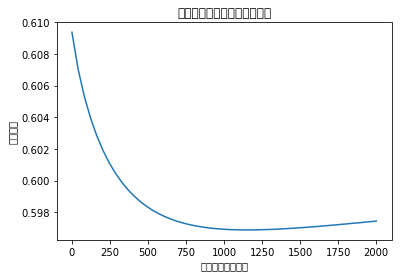

In [28]:
plt.plot(alphas_to_test,rcv3.cv_values_.mean(axis=0))
plt.title("正則化パラメータと平方誤差")
plt.xlabel("正則化パラメータ")
plt.ylabel("平方誤差");

## 特異値分解

In [0]:
from scipy.sparse.linalg import svds

rating_matrix_selected = rating_matrix.iloc[:, 1:].astype(float).as_matrix()
user_ratings_mean = np.mean(rating_matrix_selected, axis = 1)
rating_matrix_selected_demeaned = rating_matrix_selected - user_ratings_mean.reshape(-1, 1)

In [0]:
U, sigma, Vt = svds(rating_matrix_selected_demeaned, k = 50)

In [0]:
sigma = np.diag(sigma)

In [32]:
pd.DataFrame(sigma).astype(int).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating_matrix.iloc[:, 1:].columns)

In [34]:
preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,4.983346,3.297927,3.726523,3.405323,2.953049,3.512971,4.240893,2.250636,4.210446,3.921656,2.576675,4.505313,3.998228,4.415014,3.601217,3.644635,2.953825,3.192718,3.743507,3.759382,2.356627,3.111747,3.418490,3.719361,4.302330,3.167584,2.842346,3.939405,2.164836,3.248598,3.214060,3.733722,3.717540,2.619347,2.414912,2.787672,2.720591,3.318940,3.560324,3.063960,...,3.002862,2.967118,2.989516,2.984690,2.984677,2.979838,2.984677,2.989516,2.989516,2.973857,2.988631,3.004125,2.921546,3.103280,2.984677,2.988913,2.974330,2.979504,2.995399,3.011877,2.976796,3.001619,2.976796,2.976796,2.984677,2.984677,2.976796,2.984677,2.988465,2.993110,2.984677,2.978273,2.984677,3.000074,2.984677,2.972852,2.984677,2.978765,2.984677,2.984677
1,3.491652,2.980311,2.804242,2.869306,3.100262,3.127967,3.405459,3.059151,3.396606,3.039602,3.002011,3.053058,3.152598,3.617673,3.249664,3.099645,2.933226,2.966845,3.528135,3.288353,2.905368,3.169078,3.118364,3.060596,3.329189,3.028870,3.014841,2.865428,2.914833,2.923079,2.848065,3.028107,2.962840,3.002158,2.970895,2.984678,2.981997,3.186277,2.968454,3.051234,...,3.003121,2.980093,3.004018,3.001801,2.998087,2.992155,2.998087,3.004018,3.004018,2.978929,3.004762,2.995164,3.001514,3.013402,2.998087,3.001280,2.984732,2.991410,2.993249,3.000536,2.991956,2.991802,2.991956,2.991956,2.998087,2.998087,2.991956,2.998087,2.992896,2.992697,2.998087,2.993816,2.998087,2.996857,2.998087,2.992453,2.998087,2.995270,2.998087,2.998087
2,2.934865,2.956343,2.914068,3.053111,2.861561,2.989195,2.908838,3.101530,3.187782,2.931398,3.022862,2.855520,2.903609,2.943278,3.176320,2.966318,3.094370,2.978256,2.932093,2.935710,2.932928,2.886768,3.000194,3.030157,3.066221,2.893891,3.038842,3.008303,3.014676,3.020931,3.007096,2.985320,3.009937,3.004693,3.022147,2.977891,3.001965,2.923501,3.035729,3.014314,...,3.038824,3.001779,3.024182,3.013262,3.013550,3.002918,3.013550,3.024182,3.024182,3.035135,3.019824,2.989198,3.012377,2.999779,3.013550,3.020561,3.002705,3.008127,3.009201,3.001537,3.023043,3.021459,3.023043,3.023043,3.013550,3.013550,3.023043,3.013550,3.017798,3.022310,3.013550,3.008851,3.013550,3.000123,3.013550,3.018720,3.013550,3.016135,3.013550,3.013550
3,3.354358,2.979081,3.067666,2.966048,2.973696,3.019226,2.953597,2.956799,3.201462,3.013570,3.067370,3.163565,2.981179,3.164364,2.862421,3.003094,3.034926,2.997865,3.026747,3.059670,3.000728,2.902746,3.037511,2.992376,2.719748,3.015366,2.967134,3.062886,3.061339,2.981948,2.984738,2.983097,2.935475,3.014410,3.029919,3.007479,3.019607,2.907987,2.984020,2.974067,...,2.998132,3.002907,3.003604,3.003506,3.005035,3.006467,3.005035,3.003604,3.003604,2.998601,3.001784,3.004605,3.006431,2.998619,3.005035,3.003507,3.022910,3.013973,3.007464,3.011002,3.000043,3.014125,3.000043,3.000043,3.005035,3.005035,3.000043,3.005035,3.000747,3.008309,3.005035,3.005840,3.005035,3.004896,3.005035,2.984518,3.005035,2.994777,3.005035,3.005035
4,4.713029,2.707825,2.571067,2.882553,2.818342,3.070715,3.899686,3.010187,2.884579,2.925357,2.861487,2.798807,2.677977,2.937939,3.131206,3.011087,3.170768,3.086877,3.180770,2.690703,2.907141,2.833680,3.387299,3.314093,4.050739,2.982138,2.830292,3.657419,2.465809,3.167780,3.063862,3.268959,3.148540,2.976122,2.928075,3.119174,2.932824,3.001828,2.856866,2.974923,...,3.018961,3.008484,2.992215,2.993605,2.997306,3.002398,2.997306,2.992215,2.992215,2.989839,2.996175,2.964208,3.014030,2.956277,2.997306,2.992589,2.935843,2.966575,2.961910,3.014907,2.998301,3.026825,2.998301,2.998301,2.997306,2.997306,2.998301,2.997306,2.995978,3.004981,2.997306,2.989697,2.997306,3.000938,2.997306,2.999868,2.997306,2.998587,2.997306,2.997306
5,3.270270,3.141212,3.007000,3.241709,3.102009,3.11857

## PCA

In [0]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=10)
rating_pca = pca.fit_transform(rating_matrix_selected)

In [36]:
pd.DataFrame(rating_pca).shape

(943, 10)

In [37]:
pd.DataFrame(rating_pca).head(5)

,0,1,2,3,4,5,6,7,8,9
0,7.730841,1.085405,5.099150,-1.253911,-2.297061,-4.575883,0.307139,3.769845,-0.306478,0.106428
1,-1.982266,0.418045,0.455265,-1.634248,2.133859,-0.520310,-0.511968,2.631332,-0.184627,0.254957
2,-3.067438,0.553173,-0.414147,0.848285,-0.650972,-0.262826,0.740890,-0.806765,-0.387570,0.548350
3,-2.746047,-0.636941,0.097862,-0.525196,-0.127268,0.093695,-0.900255,-0.442711,-0.074961,-0.570984
4,-0.288852,0.767945,2.385567,2.260470,-3.994909,-2.822301,-1.741649,2.342063,1.918532,-0.125827


In [38]:
pca.explained_variance_ratio_

array([0.08613158, 0.03691584, 0.02066995, 0.02014702, 0.0164714 ,
       0.01303242, 0.01245348, 0.0109472 , 0.0095304 , 0.009275  ])

### PCAでの可視化

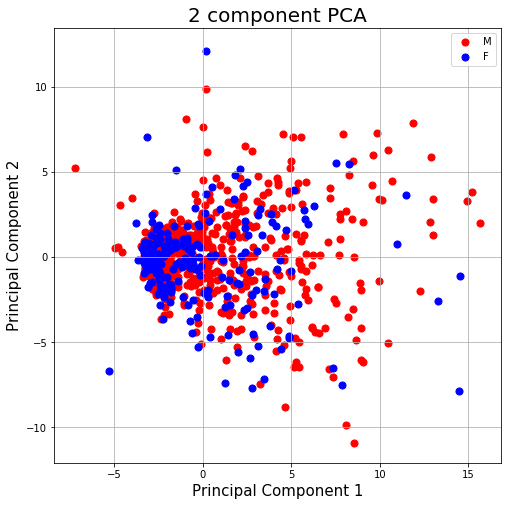

In [39]:
pca = decomposition.PCA(n_components=2,random_state=123)
principalComponents = pca.fit_transform(rating_matrix_selected)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, user.gender], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = user.gender.unique().tolist()
colors =  ['r',  'b']
for target, color in zip(targets,colors):
    indicesToKeep = user.gender == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### PCAでの可視化（3次元）

In [0]:
from mpl_toolkits.mplot3d import Axes3D

pca = decomposition.PCA(n_components=3,random_state=123)
principalComponents = pca.fit_transform(rating_matrix_selected)

user_gender = user
user_gender["gender"] = pd.Categorical(user.gender)
my_color = user_gender.gender.cat.codes
my_color = np.where(my_color == 1, "r", "b")

# Store results of PCA in a data frame
result=pd.DataFrame(principalComponents, columns=['PCA%i' % i for i in range(3)], index=rating_matrix.index)

<Figure size 480x480 with 0 Axes>

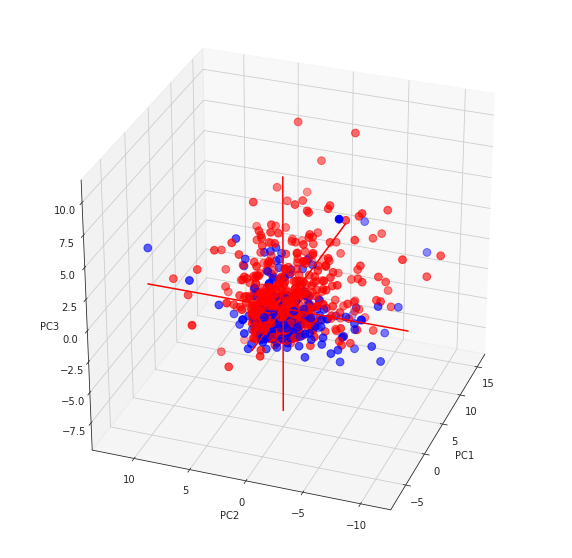

In [41]:
import seaborn as sns
sns.set_style("white")

my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi);


# Plot initialisation
fig = plt.figure(figsize=(10, 10));
ax = fig.add_subplot(111, projection='3d');
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60);
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r');

yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r');

zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r');
 
# label the axes
ax.view_init(30, 200); # 角度をいじれる
ax.set_xlabel("PC1");
ax.set_ylabel("PC2");
ax.set_zlabel("PC3");
ax.set_title("");
plt.savefig('pic.png', dpi=60);

## PCAを用いたknnによる予測

In [0]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=100)
rating_pca = pca.fit_transform(rating_matrix.iloc[:, 2:])

In [0]:
rating_pca_df = pd.DataFrame(rating_pca)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(rating_pca_df, 
                                                                                        rating_use.iloc[:,1], 
                                                                                        stratify=rating_use.iloc[:,1],
                                                                                        test_size=0.2,
                                                                                        random_state=123)

In [0]:
scalar = StandardScaler()
scalar.fit(X_train)

X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

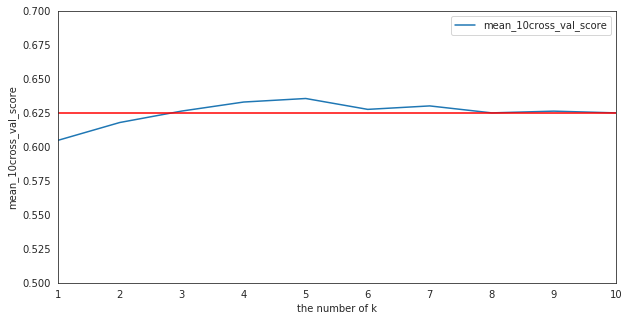

In [46]:
iteration = 11
result_table = pd.DataFrame(columns=["k", "mean_10cross_val_score"])
for i in range(1,iteration):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=10)
    
    df = pd.DataFrame([[i,knn_scores.mean()]], columns=result_table.columns)
    result_table = result_table.append(df).reset_index(drop=True)
    
ax = result_table.plot(x="k",y="mean_10cross_val_score", figsize=(10,5));
ax.set_ylabel("mean_10cross_val_score");
ax.set_xlabel("the number of k");
ax.axhline(y=0.625, color='r', linestyle='-')
ax.set_ylim([0.5, 0.7]);